In [5]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import copy
import scipy.ndimage as ndimage
from PIL import Image, ImageOps


def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

original = []
better = []
label = []
labels = []
images = []


# load image and change the dtype into array
for i in range(10):
    for j in range(10):
        image = tf.keras.preprocessing.image.load_img('./image/0'+str(i)+str(j)+'.png')
        images.append(image)
        input_arr = keras.preprocessing.image.img_to_array(image)
        original.append(input_arr)
        
for i in range(10):
    for j in range(10):
        image = tf.keras.preprocessing.image.load_img('./image/better_0'+str(i)+str(j)+'.png')
        images.append(image)
        input_arr = keras.preprocessing.image.img_to_array(image)
        better.append(input_arr)
    
# for i in range(10):
#     for j in range(10):
#         image = tf.keras.preprocessing.image.load_img('./image/doodle_0'+str(i)+str(j)+'.png')
#         images.append(image)
#         input_arr = keras.preprocessing.image.img_to_array(image)
#         data.append(input_arr)

# # create one-hot label
# for k in range(100):
#     label.append(0)
# for m in range(100):
#     label[m] = 1
#     temp = copy.deepcopy(label)
#     labels.append(temp)
#     label[m] = 0 
    
originals = np.array(original)
betters = np.array(better)
originals = originals / 255.0
betters = betters / 255.0
# labels = np.array(labels)
# labels = labels / 1.0  

# temp = tf.concat([labels, labels], axis=0)
# labels = tf.concat([temp,labels], axis=0)

# test_labels = copy.deepcopy(labels)

print(originals.shape)
print(betters.shape)

(100, 512, 512, 3)
(100, 512, 512, 3)


In [3]:
# data augmentation function
def data_aug(datas, datas2):
    
    resized_datas = copy.deepcopy(datas)
    resized_datas2 = copy.deepcopy(datas2)
    
    # 1) resize the image
    for i in range(len(resized_datas)):
        resize = int(np.round(512*np.random.uniform(0.8,1,1)))
        temp = tf.image.resize(datas[i], [resize, resize])
        temp_2 = tf.image.resize(datas2[i], [resize, resize])
        if resize >= 512:
            temp2 = tf.image.resize_with_crop_or_pad(temp, 512, 512)
            temp2_2 = tf.image.resize_with_crop_or_pad(temp_2, 512, 512)
            resized_datas[i] = temp2
            resized_datas2[i] = temp2_2
        elif resize < 512:
            imgtemp = keras.preprocessing.image.array_to_img(temp)
            imgtemp_2 = keras.preprocessing.image.array_to_img(temp_2)
            delta_w = 512 - resize
            delta_h = 512 - resize
            padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
            imgtemp2 = ImageOps.expand(imgtemp, padding, fill=(255,255,255))
            imgtemp2_2 = ImageOps.expand(imgtemp_2, padding, fill=(255,255,255))
            temp2 = keras.preprocessing.image.img_to_array(imgtemp2)
            temp2_2 = keras.preprocessing.image.img_to_array(imgtemp2_2)
            resized_datas[i] = temp2
            resized_datas2[i] = temp2_2

    # 2) rotate the resized image        
    def random_rotate_image(image, angle):
        image = ndimage.rotate(image, angle, reshape=False, mode='constant', cval=255.0)
        return image

    rot_res_datas = copy.deepcopy(datas)
    rot_res_datas2 = copy.deepcopy(datas2)

    for i in range(len(rot_res_datas)):
        angle = np.random.uniform(-45, 45)
        rot_res_datas[i] = random_rotate_image(resized_datas[i], angle)
        rot_res_datas2[i] = random_rotate_image(resized_datas2[i], angle)
   
    # 3) shift the rotated and resized image   
    train_datas = copy.deepcopy(datas)     
    train_labels = copy.deepcopy(datas2)    

    for i in range(len(train_datas)):
        shift = np.round(512*np.random.uniform(-0.1,0.1))
        shift2 = np.round(512*np.random.uniform(-0.1,0.1))
        train_datas[i] = tf.keras.preprocessing.image.apply_affine_transform(rot_res_datas[i], tx=shift, ty=shift2, 
                                                                   row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant',
                                                                   cval=255.0)
        train_labels[i] = tf.keras.preprocessing.image.apply_affine_transform(rot_res_datas2[i], tx=shift, ty=shift2, 
                                                                   row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant',
                                                                   cval=255.0)
        

    result = train_datas / 255.0
    result2 = train_labels / 255.0
    
    return result, result2

In [4]:
# create Unet model
import numpy as np
from tensorflow.keras.layers import  Flatten, Conv2D, MaxPooling2D, Dense, Dropout, Softmax, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras import Sequential
import tensorflow as tf

def contract_path(input_shape):
    input = tf.keras.layers.Input(shape = input_shape)
    x =  Conv2D(16, (3,3), padding = "same")(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(16, (3,3), padding = "same", name = "copy1")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 512 -> 256
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(32, (3,3), padding = "same", name = "copy2")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 256 -> 128
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(64, (3,3), padding = "same", name = "copy3")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 128 -> 64
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(128, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(128, (3,3), padding = "same", name = "copy4")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 64 -> 32
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(256, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(256, (3,3), padding = "same", name = "copy5")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 32 -> 16
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(512, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(512, (3,3), padding = "same", name = "copy6")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 16 -> 8
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(1024, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(1024, (3,3), padding = "same", name = "copy7")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 8 -> 4 
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(2048, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(2048, (3,3), padding = "same", name = "last_layer")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    contract_path =  tf.keras.Model(inputs = input, outputs = x)
    return contract_path

def Unet2(input_shape, n_classes):
    contract_model = contract_path(input_shape=input_shape)
    layer_names  = ["copy1", "copy2",  "copy3" ,"copy4", "copy5", "copy6", "copy7", "last_layer"]
    layers = [contract_model.get_layer(name).output for name in layer_names]

    extract_model = tf.keras.Model(inputs=contract_model.input, outputs=layers)
    input = tf.keras.layers.Input(shape=input_shape)
    output_layers = extract_model(inputs=input)
    last_layer = output_layers[-1]
    # 4 -> 8
    x = Conv2DTranspose(1024, 4, (2,2), padding = "same", activation = "relu")(last_layer)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[6]])

    x =  Conv2D(1024, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(1024, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 8 -> 16
    x = Conv2DTranspose(512, 4, (2,2), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[5]])

    x =  Conv2D(512, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(512, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 16 -> 32
    x = Conv2DTranspose(256, 4, (2,2), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[4]])

    x =  Conv2D(256, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(256, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 32 -> 64
    x = Conv2DTranspose(128, 4, (2,2), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[3]])
    
    x =  Conv2D(128, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(128, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 64 -> 128
    x = Conv2DTranspose(64, 4, (2,2), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[2]])
    
    x =  Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 128 -> 256
    x = Conv2DTranspose(32, 4, (2,2), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[1]])
    
    x =  Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    # 256 -> 512
    x = Conv2DTranspose(16, 4, (2,2), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[0]])
    
    x =  Conv2D(16, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(16, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x =  Conv2D(n_classes, (1,1), activation = "relu")(x)
    
    return tf.keras.Model(inputs = input , outputs = x)

myu2 = Unet2(input_shape=(512,512,3), n_classes=3)
myu2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       [(None, 512, 512, 16 75528208    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 8, 8, 1024)   33555456    functional_3[0][7]               
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 8, 8, 1024)   4096        conv2d_transpose[0][0]           
_______________________________________________________________________________________

In [6]:
# create Unet model
import numpy as np
from tensorflow.keras.layers import  Flatten, Conv2D, MaxPooling2D, Dense, Dropout, Softmax, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

def contract_path(input_shape):
    input = tf.keras.layers.Input(shape = input_shape)
    x =  Conv2D(16, (3,3), padding = "same", activation = "relu")(input)
    x =  Conv2D(16, (3,3), padding = "same", activation = "relu", name = "copy1")(x)
    # 512 -> 256
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(32, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(32, (3,3), padding = "same", activation = "relu", name = "copy2")(x)
    # 256 -> 128
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(64, (3,3), padding = "same", activation = "relu", name = "copy3")(x)
    # 128 -> 64
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(128, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(128, (3,3), padding = "same", activation = "relu", name = "copy4")(x)
    # 64 -> 32
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(256, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(256, (3,3), padding = "same", activation = "relu", name = "copy5")(x)
    # 32 -> 16
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(512, (3,3), padding = "same", activation = "relu", name = "copy6")(x)
    # 16 -> 8
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(1024, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(1024, (3,3), padding = "same", activation = "relu", name = "copy7")(x)
    # 8 -> 4 
    x = MaxPooling2D((2, 2))(x)
    x =  Conv2D(2048, (3,3), padding = "same", activation = "relu")(x)
    x =  Conv2D(2048, (3,3), padding = "same", activation = "relu", name = "last_layer")(x)
    contract_path =  tf.keras.Model(inputs = input, outputs = x)
    return contract_path

def Unet(input_shape, n_classes):
    contract_model = contract_path(input_shape=input_shape)
    layer_names  = ["copy1", "copy2",  "copy3" ,"copy4", "copy5", "copy6", "copy7", "last_layer"]
    layers = [contract_model.get_layer(name).output for name in layer_names]

    extract_model = tf.keras.Model(inputs=contract_model.input, outputs=layers)
    input = tf.keras.layers.Input(shape=input_shape)
    output_layers = extract_model(inputs=input)
    last_layer = output_layers[-1]
    # 4 -> 8
    x = Conv2DTranspose(1024, 4, (2,2), padding = "same", activation = "relu")(last_layer)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[6]])

    x =  Conv2D(1024, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(1024, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    # 8 -> 16
    x = Conv2DTranspose(512, 4, (2,2), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[5]])

    x =  Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(512, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    # 16 -> 32
    x = Conv2DTranspose(256, 4, (2,2), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[4]])

    x =  Conv2D(256, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(256, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    # 32 -> 64
    x = Conv2DTranspose(128, 4, (2,2), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[3]])
    
    x =  Conv2D(128, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(128, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    # 64 -> 128
    x = Conv2DTranspose(64, 4, (2,2), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[2]])
    
    x =  Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    # 128 -> 256
    x = Conv2DTranspose(32, 4, (2,2), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[1]])
    
    x =  Conv2D(32, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(32, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    # 256 -> 512
    x = Conv2DTranspose(16, 4, (2,2), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, output_layers[0]])
    
    x =  Conv2D(16, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(16, (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x =  Conv2D(n_classes, (1,1), activation = "relu")(x)
    
    return tf.keras.Model(inputs = input , outputs = x)

myu = Unet(input_shape=(512,512,3), n_classes=3)
myu.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
functional_15 (Functional)      [(None, 512, 512, 16 75503760    input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_14 (Conv2DTran (None, 8, 8, 1024)   33555456    functional_15[0][7]              
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 8, 8, 1024)   4096        conv2d_transpose_14[0][0]        
______________________________________________________________________________________

In [ ]:
myu.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'mse', 
              metrics = ['accuracy'])

for i in range(10):
    orig_data, bett_data = data_aug(originals, betters)
    myu.fit(orig_data, bett_data, batch_size=10, epochs=5)

In [ ]:
myu2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'mse', 
              metrics = ['accuracy'])

for i in range(5):
    orig_data, bett_data = data_aug(originals, betters)
    myu2.fit(orig_data, bett_data, batch_size=10, epochs=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


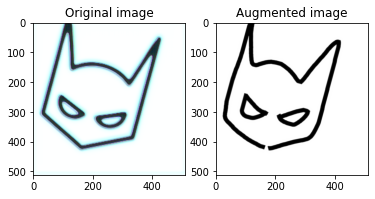

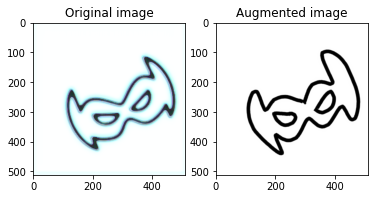

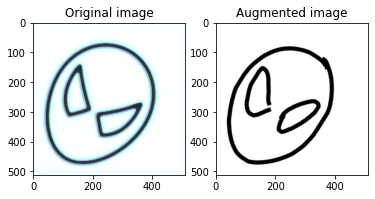

In [8]:
predictions = myu.predict(orig_data)

for i in range(3):
    visualize(predictions[i], bett_data[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


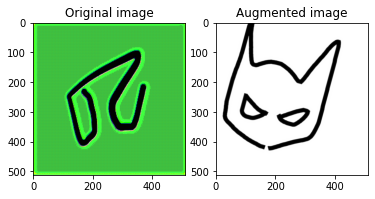

In [21]:
test = tf.keras.preprocessing.image.load_img('./111.png')
test_arr = keras.preprocessing.image.img_to_array(test)
print(type(test_arr))
test_arr = np.expand_dims(test_arr, axis=0)
predictions = myu.predict(test_arr)
visualize(predictions[0], bett_data[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


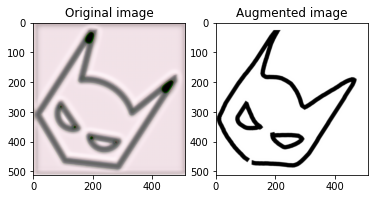

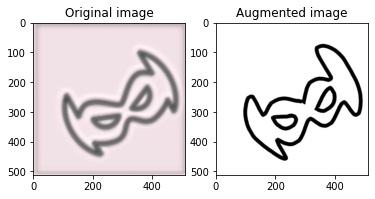

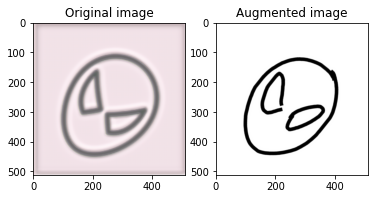

In [34]:
predictions = myu2.predict(orig_data)

for i in range(3):
    visualize(predictions[i], bett_data[i])

In [28]:
#### create Unet model
import numpy as np
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

def MyUnet(pretrained_weights = None, input_size = (512,512,3)):
    inp = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # 512 -> 256
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # 256 -> 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # 128 -> 64
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # 64 -> 32
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # 32 -> 16
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool5)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    # 16 -> 8
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    conv7 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool6)
    conv7 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    drop1 = Dropout(0.5)(conv7)
    # 8 -> 4
    pool7 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv8 = Conv2D(2048, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool7)
    conv8 = Conv2D(2048, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    drop2 = Dropout(0.5)(conv8)
    # 4 -> 8
    up9 = Conv2D(2048, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop2))
    merge9 = concatenate([drop1,up9], axis = 3)
    conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    # 8 -> 16
    up10 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv6,up10], axis = 3)
    conv10 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    # 16 -> 32
    up11 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
    merge11 = concatenate([conv5,up11], axis = 3)
    conv11 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
    conv11 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    # 32 -> 64
    up12 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv11))
    merge12 = concatenate([conv4,up12], axis = 3)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge12)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)    
    # 64 -> 128
    up13 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv12))
    merge13 = concatenate([conv3,up13], axis = 3)
    conv13 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge13)
    conv13 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)       
    # 128 -> 256
    up14 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv13))
    merge14 = concatenate([conv2,up14], axis = 3)
    conv14 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge14)
    conv14 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv14)    
    # 256 -> 512
    up15 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv14))
    merge15 = concatenate([conv1,up15], axis = 3)
    conv15 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge15)
    conv15 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)    
    conv16 = Conv2D(3, 1, activation = 'sigmoid')(conv15)
    
    model = Model(inputs = inp, outputs=[conv16])

    return model
    
MyU = MyUnet()

MyU.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 512, 512, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 512, 512, 16) 2320        conv2d_140[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 256, 256, 16) 0           conv2d_141[0][0]                 
______________________________________________________________________________________

In [29]:
MyU.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'mse', 
              metrics = ['accuracy'])

for i in range(5):
    orig_data, bett_data = data_aug(originals, betters)
    MyU.fit(orig_data, bett_data, batch_size=10, epochs=5)

Epoch 1/5
10/10 [==============================] - 2s 208ms/step - loss: 0.1416 - accuracy: 0.9866
Epoch 2/5
10/10 [==============================] - 2s 208ms/step - loss: 0.1266 - accuracy: 1.0000
Epoch 3/5
10/10 [==============================] - 2s 208ms/step - loss: 0.1266 - accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 2s 203ms/step - loss: 0.1266 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 2s 203ms/step - loss: 0.1266 - accuracy: 1.0000
Epoch 1/5
10/10 [==============================] - 2s 207ms/step - loss: 0.1200 - accuracy: 1.0000
Epoch 2/5
10/10 [==============================] - 2s 208ms/step - loss: 0.1200 - accuracy: 1.0000
Epoch 3/5
10/10 [==============================] - 2s 208ms/step - loss: 0.1200 - accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 2s 203ms/step - loss: 0.1200 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 2s 203ms/step - loss: 0.1200 - accuracy: 1.0000
Epoch 1/5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


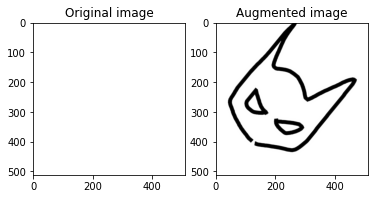

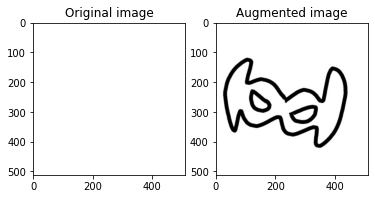

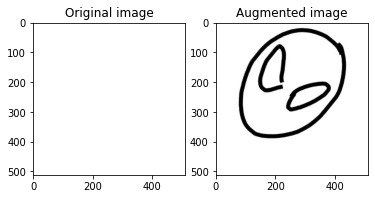

In [30]:
predict = MyU.predict(orig_data)

for i in range(3):
    visualize(predict[i], bett_data[i])